<a href="https://colab.research.google.com/github/Hakgyun-Hong/MachineLearning/blob/master/Forecasting_Inflation_with_ARIMA_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Import Library
---



In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

np.random.seed(234)
tf.random.set_seed(234)


# Load Kaggle

In [ ]:
# Load Kaggle Data
!pip install kaggle
from google.colab import files
files.upload()

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d calven22/usa-key-macroeconomic-indicators

  0% 0.00/20.5k [00:00<?, ?B/s]
100% 20.5k/20.5k [00:00<00:00, 25.6MB/s]


In [ ]:
!unzip usa-key-macroeconomic-indicators.zip
!ls

Archive:  usa-key-macroeconomic-indicators.zip
  inflating: macro_monthly.csv       
  inflating: macro_quarterly.csv     
kaggle.json	   macro_quarterly.csv	usa-key-macroeconomic-indicators.zip
macro_monthly.csv  sample_data


In [ ]:
monthly_raw = pd.read_csv('../content/macro_monthly.csv',parse_dates=True)
monthly_raw.shape

(490, 12)

# EDA : We need to see data

In [ ]:
# Drop na data here
monthly_raw.dropna(inplace=True)
monthly_raw.head(5)

,DATE,unrate,psr,m2,dspic,pce,reer,ir,ffer,tcs,indpro,ccpi
156,1994-01-01,6.6,7.1,3481.800,7363.1,4585.1,105.21,5.750500,3.050645,513314.0,67.0596,154.5
157,1994-02-01,6.6,6.5,3459.675,7377.2,4632.6,104.66,5.973158,3.245000,513196.0,67.1060,154.8
158,1994-03-01,6.5,6.8,3476.975,7401.7,4646.0,104.78,6.482609,3.335806,521040.0,67.7792,155.3
159,1994-04-01,6.4,6.4,3507.150,7402.0,4671.1,104.68,6.972105,3.555000,528063.0,68.1906,155.5
160,1994-05-01,6.1,7.6,3472.840,7487.4,4669.5,103.78,7.183333,4.010968,532328.0,68.5136,155.9


In [ ]:
# Describe data
monthly_raw.describe()

,unrate,psr,m2,dspic,pce,reer,ir,ffer,tcs,indpro,ccpi
count,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,3.340000e+02,334.000000,334.000000
mean,5.791018,6.586826,8627.829506,11394.734431,9569.229940,109.907605,3.882859,2.415848,9.720143e+05,92.777456,212.386814
std,1.787387,3.120379,4364.338305,2341.243964,3098.674682,8.971247,1.752293,2.234888,2.730147e+05,9.163744,33.961535
min,3.500000,2.100000,3459.675000,7363.100000,4585.100000,93.060000,0.623636,0.049000,5.131960e+05,67.059600,154.500000
25%,4.600000,5.100000,4949.231250,9655.550000,6961.000000,102.042500,2.355000,0.158871,7.964818e+05,88.939700,183.450000
50%,5.400000,6.500000,7462.277500,11517.950000,9800.200000,111.100000,3.875000,1.741434,9.188880e+05,94.752400,212.914000
75%,6.200000,7.300000,11579.775000,13050.000000,12032.075000,116.485000,5.163647,4.978331,1.161412e+06,99.832125,239.391250
max,14.800000,33.800000,21152.350000,19119.500000,16290.700000,129.030000,7.955000,6.544516,1.598020e+06,104.165900,281.695000


In [ ]:
# See Data type
monthly_raw.dtypes

DATE       object
unrate    float64
psr       float64
m2        float64
dspic     float64
pce       float64
reer      float64
ir        float64
ffer      float64
tcs       float64
indpro    float64
ccpi      float64
dtype: object

In [ ]:
# Change into datetime type
# column DATE is object type. but i need time series data...
monthly_raw.DATE = pd.to_datetime(monthly_raw.DATE)

In [ ]:
# Check time domain
monthly_raw['DATE'].nunique()

334

- we could see that 334 is number of unique data

In [ ]:
import copy
monthly_df = copy.deepcopy(monthly_raw)

# Macroeconomic Indicator

In [ ]:
# make cpi data pct by month and year
monthly_df['cpi_pct_mom'] = round((monthly_df['ccpi'].pct_change().fillna(0))*100,2)
monthly_df['cpi_pct_yoy'] = round((monthly_df['ccpi'].pct_change(12).fillna(0))*100,2)

Text(0.5, 0.98, '27 Year Macro Indicators for the United States')

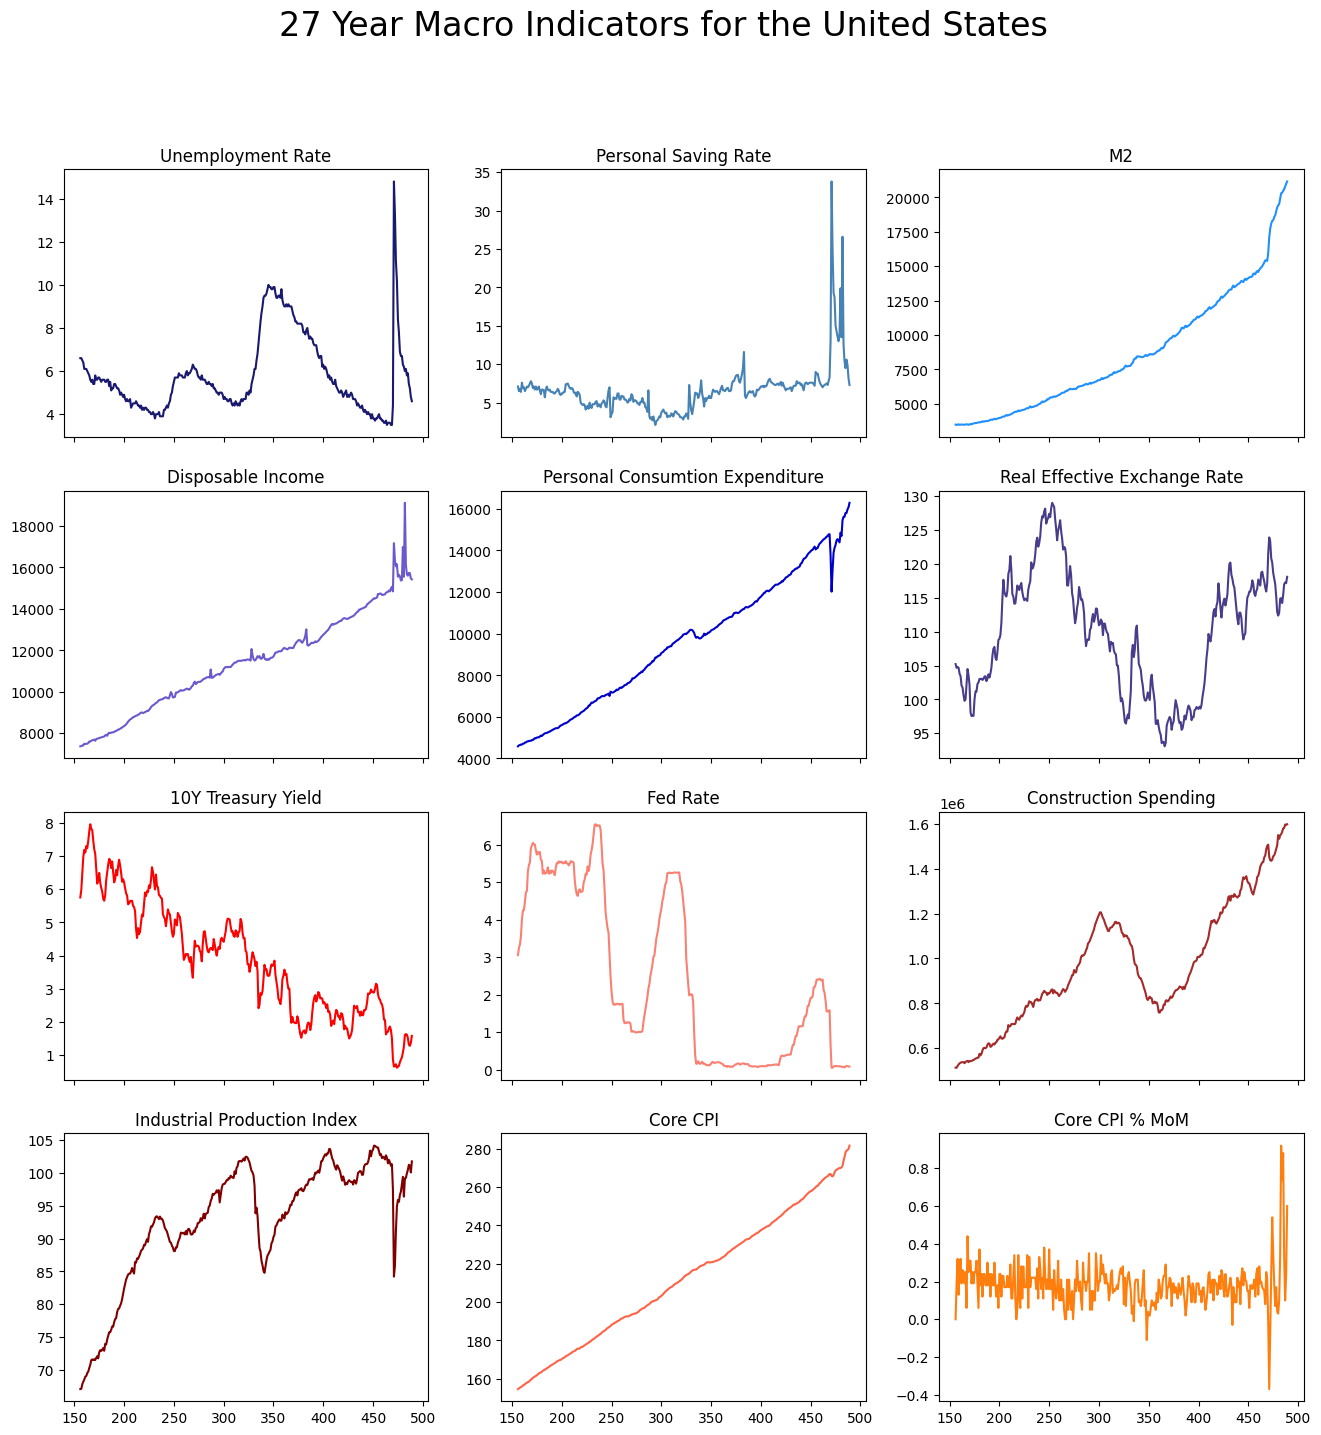

In [ ]:
monthly_df.iloc[:, 1:13].plot(kind='line',
                            subplots=True,
                            figsize=(16,16),
                            title = ['Unemployment Rate','Personal Saving Rate', 'M2', 'Disposable Income',
                                     'Personal Consumtion Expenditure','Real Effective Exchange Rate',
                                     '10Y Treasury Yield' ,'Fed Rate', 'Construction Spending', 'Industrial Production Index',
                                     'Core CPI','Core CPI % MoM'],
                            legend = False,
                            layout = (4,3),
                            sharex = True,
                            style = ['midnightblue', 'steelblue', 'dodgerblue', 'slateblue','mediumblue','darkslateblue','red','salmon','brown','maroon','tomato']
                            )
plt.suptitle('27 Year Macro Indicators for the United States', fontsize=24)





# Core CPI trend by Month and Quarter

In [ ]:
# make time stamp by using lambda
monthly_df['year'] = monthly_df['DATE'].apply(lambda x:x.year)
monthly_df['quarter'] = monthly_df['DATE'].apply(lambda x:x.quarter)
monthly_df['month'] = monthly_df['DATE'].apply(lambda x:x.month)

In [ ]:
import plotly.express as px

# boxplot 1 : cpi pct yoy
fig = px.box(monthly_df[12:],x='month',y='cpi_pct_yoy', points ="all",template="presentation")
fig.update_layout(
    xaxis=dict(
        tickmode = 'linear',
    )
)

# boxplot 2 :
fig = px.box(monthly_df[12:],x='quarter',y='cpi_pct_yoy', points='all',template='presentation')

fig.show()

In [ ]:
# see deepen cpi data.

fig = px.bar(
    data_frame = monthly_df.groupby(['month']).std().reset_index(),
    x='month',
    y='cpi_pct_yoy', text = 'cpi_pct_yoy',
).update_traces(texttemplate='%{text:0.3f}', textposition='outside').update_xaxes(nticks=13)
fig.show()

fig = px.bar(
    data_frame=monthly_df.groupby(['quarter']).std().reset_index(),
    x='quarter',
    y='cpi_pct_yoy', text = 'cpi_pct_yoy',
).update_traces(texttemplate='%{text:0.3f}', textposition='outside').update_xaxes(nticks=5)

fig.show()

# Forecasting Inflation

In [ ]:
# Recheck raw data here
monthly_raw.shape
monthly_raw.head(5)

,DATE,unrate,psr,m2,dspic,pce,reer,ir,ffer,tcs,indpro,ccpi
156,1994-01-01,6.6,7.1,3481.800,7363.1,4585.1,105.21,5.750500,3.050645,513314.0,67.0596,154.5
157,1994-02-01,6.6,6.5,3459.675,7377.2,4632.6,104.66,5.973158,3.245000,513196.0,67.1060,154.8
158,1994-03-01,6.5,6.8,3476.975,7401.7,4646.0,104.78,6.482609,3.335806,521040.0,67.7792,155.3
159,1994-04-01,6.4,6.4,3507.150,7402.0,4671.1,104.68,6.972105,3.555000,528063.0,68.1906,155.5
160,1994-05-01,6.1,7.6,3472.840,7487.4,4669.5,103.78,7.183333,4.010968,532328.0,68.5136,155.9


In [ ]:
# define df_cpi : domain : DATE
df_cpi = monthly_raw.set_index('DATE')

In [ ]:
df_cpi.head(5)

,unrate,psr,m2,dspic,pce,reer,ir,ffer,tcs,indpro,ccpi
DATE,,,,,,,,,,,
1994-01-01,6.6,7.1,3481.800,7363.1,4585.1,105.21,5.750500,3.050645,513314.0,67.0596,154.5
1994-02-01,6.6,6.5,3459.675,7377.2,4632.6,104.66,5.973158,3.245000,513196.0,67.1060,154.8
1994-03-01,6.5,6.8,3476.975,7401.7,4646.0,104.78,6.482609,3.335806,521040.0,67.7792,155.3
1994-04-01,6.4,6.4,3507.150,7402.0,4671.1,104.68,6.972105,3.555000,528063.0,68.1906,155.5
1994-05-01,6.1,7.6,3472.840,7487.4,4669.5,103.78,7.183333,4.010968,532328.0,68.5136,155.9


In [ ]:
# :) I just like to check here.
df_cpi.dtypes

unrate    float64
psr       float64
m2        float64
dspic     float64
pce       float64
reer      float64
ir        float64
ffer      float64
tcs       float64
indpro    float64
ccpi      float64
dtype: object

In [ ]:
df_cpi.index

DatetimeIndex(['1994-01-01', '1994-02-01', '1994-03-01', '1994-04-01',
               '1994-05-01', '1994-06-01', '1994-07-01', '1994-08-01',
               '1994-09-01', '1994-10-01',
               ...
               '2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01',
               '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01',
               '2021-09-01', '2021-10-01'],
              dtype='datetime64[ns]', name='DATE', length=334, freq=None)

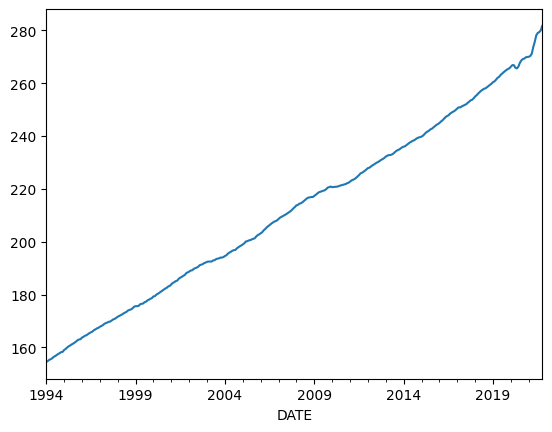

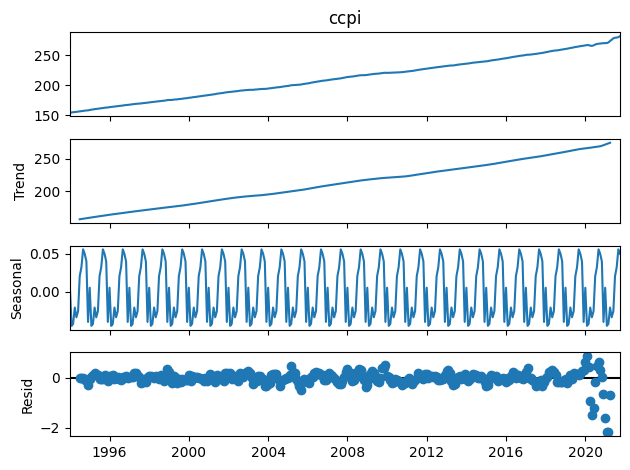

In [ ]:
df_cpi['ccpi'].plot()
fig = seasonal_decompose(df_cpi['ccpi'], model='additive').plot()

- Time Series Decomposition
> Decompose the data into trend, seasonal, Residual

Training dataset: 322, Test dataset: 12


<Axes: xlabel='DATE'>

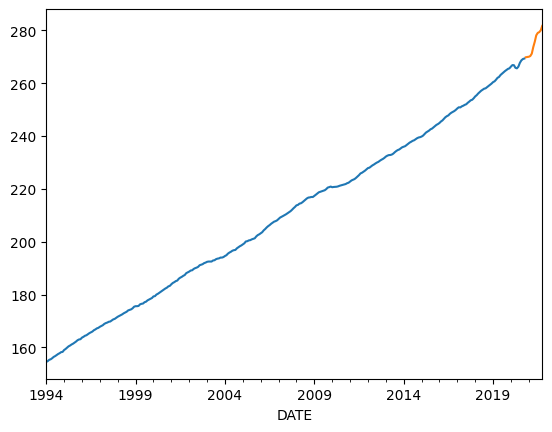

In [ ]:
# Split train/test data
split_point = len(df_cpi)-12

train, test = df_cpi[0:split_point],df_cpi[split_point:]
print('Training dataset: %d, Test dataset: %d' % (len(train), len(test)))
train['ccpi'].plot()
test['ccpi'].plot()

# Take first differences

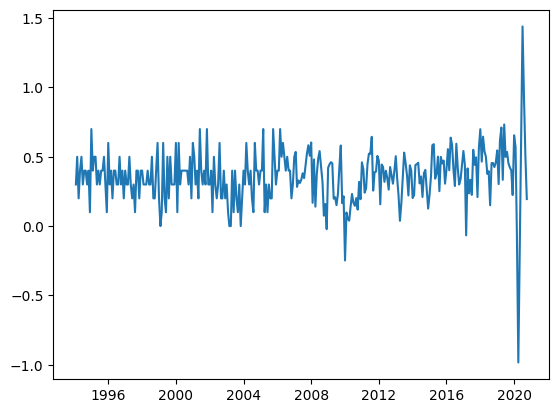

In [ ]:
# I gonna get ARIMA model. because of this, need to get stationary data.
# But the data above here is not stationary.
# Of course I know, most of cases are gonna be stationary when they got diff function
diff = train['ccpi'].diff()
plt.plot(diff)
plt.show()
diff = diff.dropna()

# Augmentted Dickey-Fuller Test

In [ ]:
# Do adf test.
# We know in statistics.
# I guess H0: stationary H1: nonstationary

def adf_test(df):
  result = adfuller(df.values)
  if result[1]>0.05:
    print("Series is not stationary")
  else:
    print("Series is stationary")

adf_test(diff)

Series is stationary


# ACF, PACF

- honestly, this is difficult sequence to me.
- But it is obvious to get p,q values.
- this is important to get timeseries  model.
- p means the lag number
- q means the order of MA terms in ARIMA

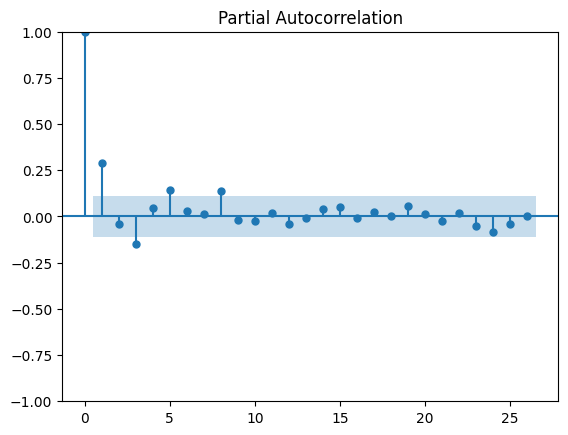

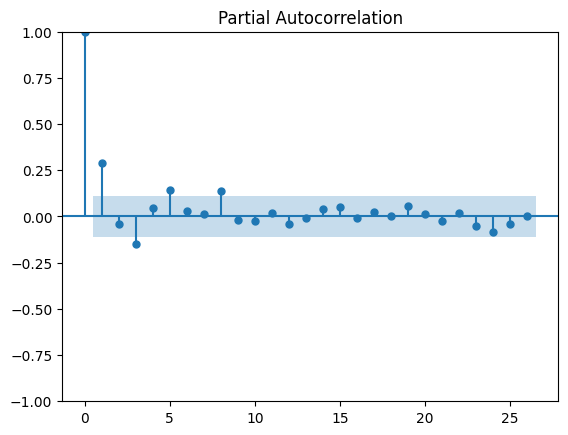

In [ ]:
plot_pacf(diff.values)

- from here q = 1,2 is significant. conservationally we choose 1

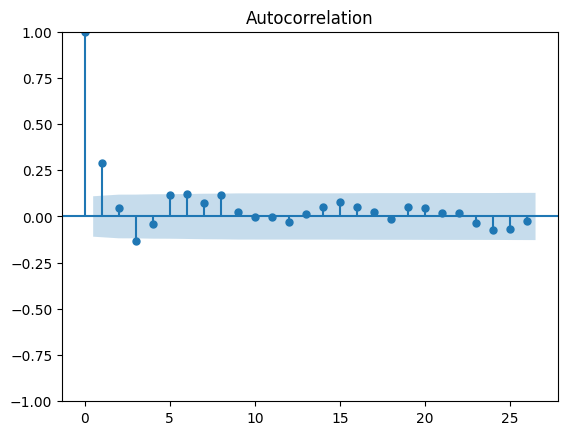

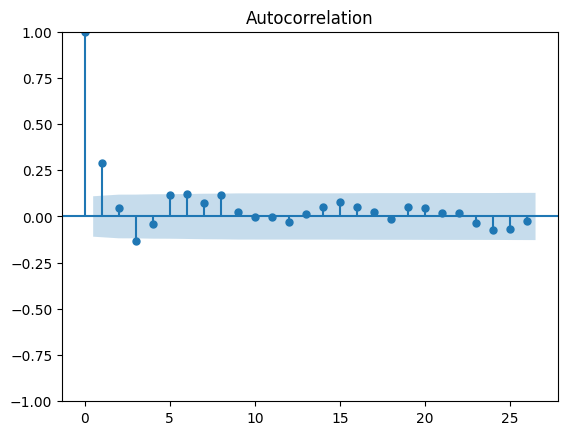

In [ ]:
plot_acf(diff.values)

# Building the model

In [ ]:
arima_model = ARIMA(np.log(train['ccpi']), order=(1,1,1))
# Because we choose ARIMA(p,k,q) Model.
# P : AR, K : diff, Q : MA

arima_fit = arima_model.fit()
arima_fit.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   ccpi   No. Observations:                  322
Model:                 ARIMA(1, 1, 1)   Log Likelihood                1780.484
Date:                Sat, 12 Aug 2023   AIC                          -3554.968
Time:                        09:49:28   BIC                          -3543.654
Sample:                    01-01-1994   HQIC                         -3550.450
                         - 10-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9682      0.016     59.833      0.000       0.937       1.000
ma.L1         -0.5010      0.043    -11.606      0.000      -0.586      -0.416
sigma2      8.851e-07   4.25e-08     20.833      0.000    8.02e-07    9.68e-07
===================================================================================
Ljung-Box (L1) (Q):                   3.44   Jarque-Bera (JB):               180.01
Prob(Q):                              0.06   Prob(JB):                         0.00
Heteroskedasticity (H):               0.96   Skew:                             0.27
Prob(H) (two-sided):                  0.84   Kurtosis:                         6.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The forecast U.S. Core Consumer Price Index (CPI) YoY is  1.39


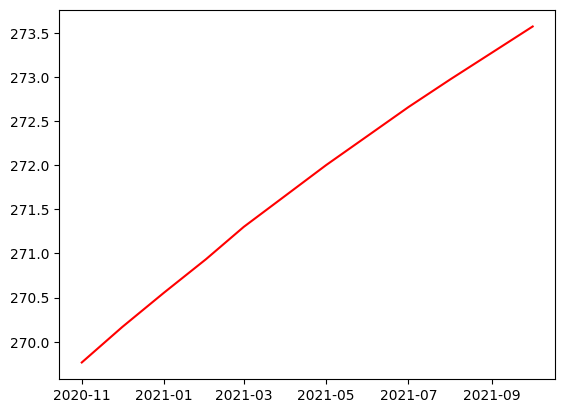

In [ ]:
forecast = arima_fit.forecast(steps=12)
forecast = np.exp(forecast)

plt.plot(forecast, color = 'red')

pct_chg = ((forecast[-1] - df_cpi.iloc[-12]['ccpi'])/df_cpi.iloc[-12]['ccpi'])*100
print('The forecast U.S. Core Consumer Price Index (CPI) YoY is ', round(pct_chg,2))

# Evaluation the ARIMA model

In [ ]:
mse = mean_squared_error
print('MSE: ',mse)
model_error = test['ccpi'] - forecast
print('Mean Model Error : ', model_error.mean())

MSE:  <function mean_squared_error at 0x79d8fadd5b40>
Mean Model Error :  3.1464952666371317


# 1-Step Forecast for November 2021

In [ ]:
arima_model = ARIMA(np.log(test['ccpi']), order = (1,1,1), freq=test.index.inferred_freq)

arima_fit = arima_model.fit()

forecast = arima_fit.forecast(steps=1)
forecast = np.exp(forecast)

print('The Core CPI value for the month November 2021 predicted by ARIMA model is ',
      round(forecast[0],2))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



The Core CPI value for the month November 2021 predicted by ARIMA model is  283.19


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [ ]:
test.index.inferred_freq

'MS'

# Univariate Time Series Forecasting with LSTM

- LSTM(Long Short Term Memory) is popular in making prediction based on time series data. due to the lags of unknown duration.
- LSTM addresses that issue of vanishing gradient with multiple switch gates
- This means it can be easily corrupted by being multiplied many time by small numbers < 0. This is the cause of vanishing gradients.

In [ ]:
df_cpi['ccpi']

DATE
1994-01-01    154.500
1994-02-01    154.800
1994-03-01    155.300
1994-04-01    155.500
1994-05-01    155.900
               ...   
2021-06-01    278.140
2021-07-01    279.054
2021-08-01    279.338
2021-09-01    280.017
2021-10-01    281.695
Name: ccpi, Length: 334, dtype: float64

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
#dataset = scaler.fit_transform(df_cpi['ccpi'].reshape(-1,1))
#dataset = scaler.fit_transform(ccpi.reshape(-1,1))
dataset = scaler.fit_transform(df_cpi['ccpi'].values.reshape(-1,1))

# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
  X, y = list(), list()
  for i in range(len(sequence)):
    end_ix = i + n_steps

    if end_ix > len(sequence)-1 :
      break

    seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
    X.append(seq_x)
    y.append(seq_y)
  return np.array(X), np.array(y)


In [ ]:
n_steps_in = 12
train, test = dataset[0:310], dataset[310:len(dataset),:]

trainX, trainY = split_sequence(train, n_steps_in)
testX, testY = split_sequence(test, n_steps_in)

# Training the model

- here I builded vanilla model with a single layer.
- Just no dropout and no early stopping.
- The number of neurons taht will be used is 100, for high dimensionality(so the model can capture the trends)
- Most parameters are chosen through a fine-tuning and trial-and-error approach.

- In this problem, The number of layer, 1 is chosen because of the complexity of the problem.

- if I use dropout in 1 layer structure, this cause losing important information.
- Dropout regularization at optimal levels 0.1/0.2 for LSTM.
- Dropout oftenly erase important context information, especially in this problem with limited timesteps and 1 layer.
- Similarly, a small learning rate of 0.001 is used due to size of the neural network and small data size.

The batch size is set as 100 epochs. Batch size fine tuning is done based on the observatino of model performance.

<function matplotlib.pyplot.show(close=None, block=None)>

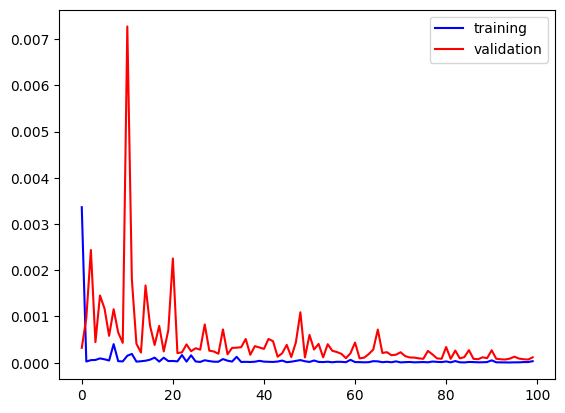

In [ ]:
n_features = trainX.shape[2]

uni_model = Sequential()

# Adding the LSTM layer
uni_model.add(LSTM(64, input_shape=(trainX.shape[1],n_features)))

# Adding the output layer
uni_model.add(Dense(1))

uni_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss = 'mean_squared_error', metrics = ['mean_absolute_error'])

fit = uni_model.fit(trainX, trainY, validation_data=(testX,testY),
                    epochs = 100, batch_size=1,
                    verbose=0)


plt.plot(fit.history['loss'], label='training', color = 'Blue')
plt.plot(fit.history['val_loss'], label='validation', color = 'Red')
plt.legend()
plt.show

# Predictions on Test set

In [ ]:
trainPredict = uni_model.predict(trainX)
testPredict = uni_model.predict(testX)

1/1 [==============================] - 0s 24ms/step


In [ ]:
# get predict and real
Ytrain_hat = scaler.inverse_transform(trainPredict)
Ytrain_actual = scaler.inverse_transform(trainY)
Ytest_hat = scaler.inverse_transform(testPredict)
Ytest_actual = scaler.inverse_transform(testY)

In [ ]:
# Evaluating Model
trainScore = mean_squared_error(Ytrain_actual, Ytrain_hat[:,0])
print('Train Score : %.2f MSE' % (trainScore))
testScore = mean_squared_error(Ytest_actual,Ytest_hat[:,0])
print('Test Score : %.2f MSE' %(testScore))

Train Score : 0.04 MSE
Test Score : 1.88 MSE


In [ ]:
model_error = Ytest_actual - Ytest_hat[:,0]
print('Mean Model Error : ',model_error.mean())

Mean Model Error :  0.8870837198893184


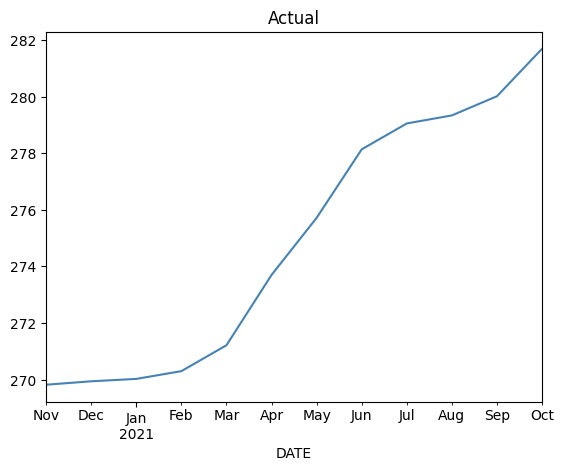

In [ ]:
observed = df_cpi.loc['2020-11-01':'2021-10-01',['ccpi']]
observed.plot(color = 'SteelBlue', title='Actual', legend=False)
plt.show()

predicted = pd.DataFrame(Ytest_hat, index=pd.date_range('2020-11-01',periods=12,freq='M'))

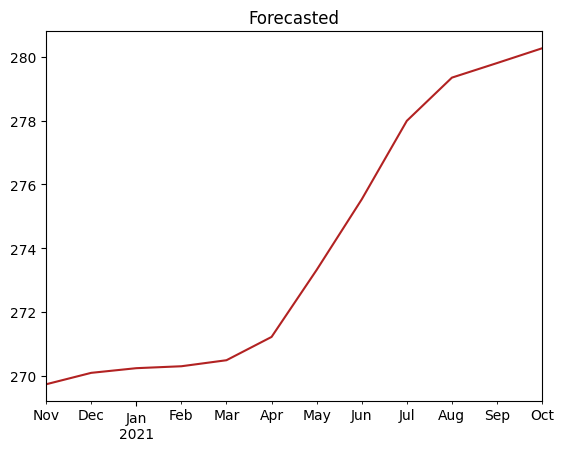

In [ ]:
predicted.plot(color ='Firebrick', title = 'Forecasted', legend = False)
plt.show()

# Forecast for November

- from here I like to predict November data by using 12 month data.
- i input the last 12 observation data

In [ ]:
# input data
x_input = np.array(dataset[-12:])
x_input = x_input.reshape((1,n_steps_in,n_features))

In [ ]:
# prediction
forecast_normalized = uni_model.predict(x_input)

1/1 [==============================] - 0s 26ms/step


In [ ]:
# rescale
forecast = scaler.inverse_transform(forecast_normalized)
print('The Core CPI value for the month Nov 2021 : ',forecast[0][0])

The Core CPI value for the month Nov 2021 :  281.54633


In [ ]:
# percentage change
pct_chg = ((forecast[0][0] - df_cpi.iloc[-12]['ccpi'])/df_cpi.iloc[-12]['ccpi'])*100
print('The forecasted U.S. Core Consumer Price Index (CPI) YoY is ' , round(pct_chg,2))

The forecasted U.S. Core Consumer Price Index (CPI) YoY is  4.35


# Multivariate LSTM Model

- Feature selection with Granger Casuality Test

In [ ]:
monthly_df_stationary = df_cpi.diff().dropna()
monthly_df_stationary = monthly_df_stationary.rename_axis('indicator', axis=1)
fig = px.line(monthly_df_stationary.iloc[:,0:10], facet_col = 'indicator', facet_col_wrap=1)
fig.update_yaxes(visible=False)

In [ ]:
# ADF Test
for indi in monthly_df_stationary:
  print('ADF TEST:',indi)
  adf_test(monthly_df_stationary[[indi]])

ADF TEST: unrate
Series is stationary
ADF TEST: psr
Series is stationary
ADF TEST: m2
Series is not stationary
ADF TEST: dspic
Series is stationary
ADF TEST: pce
Series is stationary
ADF TEST: reer
Series is stationary
ADF TEST: ir
Series is stationary
ADF TEST: ffer
Series is stationary
ADF TEST: tcs
Series is not stationary
ADF TEST: indpro
Series is stationary
ADF TEST: ccpi
Series is not stationary


In [ ]:
# Diffing the data that is not stationy
monthly_df_stationary[['m2']] = monthly_df_stationary[['m2']].diff().dropna()
monthly_df_stationary[['tcs']] = monthly_df_stationary[['tcs']].diff().dropna()
monthly_df_stationary[['ccpi']] = monthly_df_stationary[['ccpi']].diff().dropna()

In [ ]:
# Drop any NaNs
monthly_df_stationary = monthly_df_stationary.dropna()

In [ ]:
# ADF Test again
for indi in monthly_df_stationary:
  print('ADF TEST:',indi)
  adf_test(monthly_df_stationary[[indi]])

ADF TEST: unrate
Series is stationary
ADF TEST: psr
Series is stationary
ADF TEST: m2
Series is stationary
ADF TEST: dspic
Series is stationary
ADF TEST: pce
Series is stationary
ADF TEST: reer
Series is stationary
ADF TEST: ir
Series is stationary
ADF TEST: ffer
Series is stationary
ADF TEST: tcs
Series is stationary
ADF TEST: indpro
Series is stationary
ADF TEST: ccpi
Series is stationary


In [ ]:
maxlag=12
test = 'ssr_chi2test'

def grangers_causation_matrix(data, variables, test='ssr_chi2test',verbose=False):
  df = pd.DataFrame(np.zeros((len(variables),len(variables))), columns =variables, index=variables)
  for c in df.columns:
    for r in df.index:
      test_result = grangercausalitytests(data[[r,c]],maxlag=maxlag, verbose=False)
      p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
      if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
      min_p_value = np.min(p_values)
      df.loc[r,c] = min_p_value

  df.columns =[var + '_x' for var in variables]
  df.index = [var + '_y' for var in variables]
  return df

In [ ]:
grangers_causation_matrix(monthly_df_stationary, variables = monthly_df_stationary.columns)

,unrate_x,psr_x,m2_x,dspic_x,pce_x,reer_x,ir_x,ffer_x,tcs_x,indpro_x,ccpi_x
unrate_y,1.0000,0.0018,0.0000,0.0677,0.0000,0.0011,0.0015,0.0000,0.1951,0.0000,0.0022
psr_y,0.0000,1.0000,0.0000,0.0000,0.0000,0.0277,0.0200,0.0000,0.0001,0.0000,0.0000
m2_y,0.0000,0.0000,1.0000,0.0000,0.0000,0.0163,0.0468,0.0000,0.0275,0.0000,0.0000
dspic_y,0.0000,0.0000,0.0000,1.0000,0.0000,0.1799,0.1497,0.0027,0.0000,0.0000,0.0000
pce_y,0.0000,0.0002,0.0000,0.0000,1.0000,0.0059,0.0218,0.0000,0.0103,0.0000,0.0005
reer_y,0.2565,0.3279,0.0335,0.2618,0.2323,1.0000,0.0601,0.5281,0.5866,0.1191,0.0266
ir_y,0.6902,0.5921,0.5635,0.5920,0.6647,0.0733,1.0000,0.3952,0.3772,0.1995,0.4451
ffer_y,0.0390,0.1214,0.3441,0.2271,0.1104,0.7364,0.0000,1.0000,0.0242,0.6030,0.7319
tcs_y,0.0019,0.0004,0.0009,0.0035,0.0000,0.0011,0.0858,0.0486,1.0000,0.0013,0.1132
indpro_y,0.0000,0.0000,0.0000,0.0002,0.0000,0.0011,0.0003,0.0000,0.0328,1.0000,0.0008


In [ ]:
# Get Features. by considering significance level : 0.05
feat_df = df_cpi.drop(['reer','ir','ffer'],axis=1)

In [ ]:
# Scaling with Min-Max Normalization
scaled = scaler.fit_transform(feat_df)

In [ ]:
scaled_df = pd.DataFrame(scaled, columns=feat_df.columns, index=feat_df.index)
scaled_df.head(5)

,unrate,psr,m2,dspic,pce,tcs,indpro,ccpi
DATE,,,,,,,,
1994-01-01,0.274336,0.157729,0.001251,0.000000,0.000000,0.000109,0.000000,0.000000
1994-02-01,0.274336,0.138801,0.000000,0.001199,0.004058,0.000000,0.001250,0.002359
1994-03-01,0.265487,0.148265,0.000978,0.003283,0.005203,0.007231,0.019393,0.006290
1994-04-01,0.256637,0.135647,0.002683,0.003309,0.007347,0.013705,0.030480,0.007862
1994-05-01,0.230088,0.173502,0.000744,0.010573,0.007210,0.017636,0.039185,0.011007


In [ ]:
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        #find end of pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out - 1

        #check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break

        #gather input and output
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix - 1:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)

    return np.array(X), np.array(y)

In [ ]:
#inputs
in_cpi = np.array(scaled_df.loc['1994-01-01':'2019-11-01', ['ccpi']])
in_ur = np.array(scaled_df.loc['1994-01-01':'2019-11-01', ['unrate']])
in_m2  = np.array(scaled_df.loc['1994-01-01':'2019-11-01', ['m2']])
in_pce = np.array(scaled_df.loc['1994-01-01':'2019-11-01', ['pce']])
in_dspic  = np.array(scaled_df.loc['1994-01-01':'2019-11-01', ['dspic']])
in_tcs = np.array(scaled_df.loc['1994-01-01':'2019-11-01', ['tcs']])
in_psr = np.array(scaled_df.loc['1994-01-01':'2019-11-01', ['psr']])
in_ind = np.array(scaled_df.loc['1994-01-01':'2019-11-01', ['indpro']])

test_cpi = np.array(scaled_df.loc['2019-12-01':'2021-10-01', ['ccpi']])
test_ur = np.array(scaled_df.loc['2019-12-01':'2021-10-01', ['unrate']])
test_pce = np.array(scaled_df.loc['2019-12-01':'2021-10-01', ['pce']])
test_dspic  = np.array(scaled_df.loc['2019-12-01':'2021-10-01', ['dspic']])
test_m2  = np.array(scaled_df.loc['2019-12-01':'2021-10-01', ['m2']])
test_tcs = np.array(scaled_df.loc['2019-12-01':'2021-10-01', ['tcs']])
test_psr = np.array(scaled_df.loc['2019-12-01':'2021-10-01', ['psr']])
test_ind = np.array(scaled_df.loc['2019-12-01':'2021-10-01', ['indpro']])

#output
trainoutput_cpi = in_cpi
testoutput_cpi = test_cpi

In [ ]:
in_cpi = in_cpi.reshape((len(in_cpi), 1))
in_ur = in_ur.reshape((len(in_ur), 1))
in_pce = in_pce.reshape((len(in_pce), 1))
in_dspic = in_dspic.reshape((len(in_dspic), 1))
in_m2  = in_m2.reshape((len(in_m2), 1))
in_tcs = in_tcs.reshape((len(in_tcs), 1))
in_psr = in_psr.reshape((len(in_psr), 1))
in_ind = in_ind.reshape((len(in_ind), 1))

test_cpi = test_cpi.reshape((len(test_cpi), 1))
test_ur = test_ur.reshape((len(test_ur), 1))
test_pce = test_pce.reshape((len(test_pce), 1))
test_dspic = test_dspic.reshape((len(test_dspic), 1))
test_m2  = test_m2.reshape((len(test_m2), 1))
test_tcs = test_tcs.reshape((len(test_tcs), 1))
test_psr = test_psr.reshape((len(test_psr), 1))
test_ind = test_ind.reshape((len(test_ind), 1))

trainoutput_cpi = trainoutput_cpi.reshape((len(trainoutput_cpi), 1))
testoutput_cpi = testoutput_cpi.reshape((len(testoutput_cpi), 1))

In [ ]:
trainset = np.hstack((in_cpi, in_ur, in_pce, in_dspic, in_m2, in_tcs, in_psr, in_ind, trainoutput_cpi))
testset = np.hstack((test_cpi, test_ur, test_pce, test_dspic, test_m2, test_tcs, test_psr, test_ind, testoutput_cpi))
# hstack : horizontal stacking
n_steps_in = 12
n_steps_out = 1

trainX, trainy = split_sequences(trainset, n_steps_in, n_steps_out)
testX, testy = split_sequences(testset, n_steps_in, n_steps_out)

trainX.shape, trainy.shape

((300, 12, 8), (300, 1))

# Training the Model

In [ ]:
n_features = trainX.shape[2]

multi_model = Sequential()

In [ ]:
# Adding the LSTM layer and dropout regularization
multi_model.add(LSTM(100, return_sequences=True, input_shape=(n_steps_in,n_features)))
multi_model.add(LSTM(100))
multi_model.add(Dropout(0.2))

In [ ]:
# Adding output layer
multi_model.add(Dense(n_steps_out))
multi_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

In [ ]:
# Define EarlyStopping
earlystop = EarlyStopping(monitor='val_loss', patience=50,
                          mode = 'min', verbose = 0)

In [ ]:
fit = multi_model.fit(trainX,trainy, validation_data=(testX,testy),
                      epochs=500, verbose=0, callbacks=[earlystop])

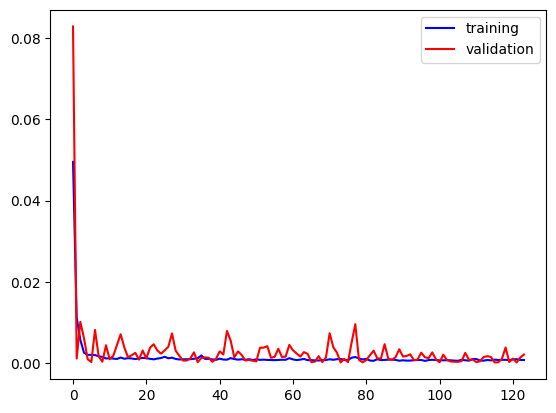

In [ ]:
# Check for overfitting
plt.plot(fit.history['loss'], label = 'training', color = 'Blue')
plt.plot(fit.history['val_loss'], label = 'validation', color = 'Red')
plt.legend()
plt.show()

In [ ]:
# define fcn for feature importance
def feature_importance(model, g):
    random_ind = np.random.choice(g.shape[0], 100, replace=False) # Randomly generate 100 numbers arange(218)
    x = g[random_ind] #  Take 100 random sample from training set
    orig_out = model.predict(x)
    for i in range(8):  # iterate over the 7 features
        new_x = x.copy()
        perturbation_in = np.random.normal(0.0, 0.7, size=new_x.shape[:2]) # Draw random samples from normal distribution with sd = 0.7, this value is arbitary and would not affect the order of effect as its just introducing noise.
        new_x[:, :, i] = new_x[:, :, i] + perturbation_in
        perturbed_out = model.predict(new_x)
        effect = ((orig_out - perturbed_out) ** 2).mean() ** 0.5
        print(f'Variable {i+1}, Perturbation Effect: {effect:.3f}')

In [ ]:
feature_importance(multi_model,trainX)

4/4 [==============================] - 0s 9ms/step
Variable 1, Perturbation Effect: 0.068
4/4 [==============================] - 0s 7ms/step
Variable 2, Perturbation Effect: 0.014
4/4 [==============================] - 0s 7ms/step
Variable 3, Perturbation Effect: 0.037
4/4 [==============================] - 0s 8ms/step
Variable 4, Perturbation Effect: 0.044
4/4 [==============================] - 0s 8ms/step
Variable 5, Perturbation Effect: 0.071
4/4 [==============================] - 0s 11ms/step
Variable 6, Perturbation Effect: 0.005
4/4 [==============================] - 0s 8ms/step
Variable 7, Perturbation Effect: 0.004
4/4 [==============================] - 0s 7ms/step
Variable 8, Perturbation Effect: 0.010


In [ ]:
testPredict = multi_model.predict(testX)

1/1 [==============================] - 0s 29ms/step


In [ ]:
testX = testX.reshape((testX.shape[0], testX.shape[2]*testX.shape[1]))

In [ ]:
# Invert Scaling for Predicted
testY_hat = np.concatenate((testX[:,1:8], testPredict), axis=1)
testY_hat = scaler.inverse_transform(testY_hat)

testY_hat = testY_hat[:,7]

In [ ]:
# Invert Scaling for Actual
testY_actual = np.concatenate((testX[:,1:8],testY), axis=1)
testY_actual = scaler.inverse_transform(testY_actual)

testY_actual = testY_actual[:,7]

# Evaluating the multivariate LSTM

In [ ]:
mse = mean_squared_error(testY_actual, testY_hat)
print('Test MSE: %.3f' % mse)

model_error = testY_actual - testY_hat
print('Mean Model Error: ', model_error.mean())

Test MSE: 33.478
Mean Model Error:  -5.61072055762511


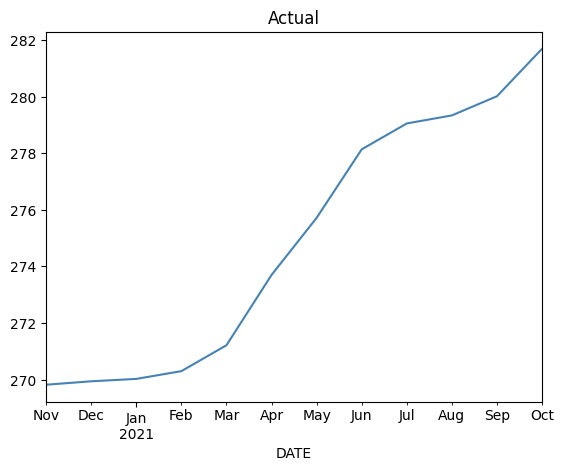

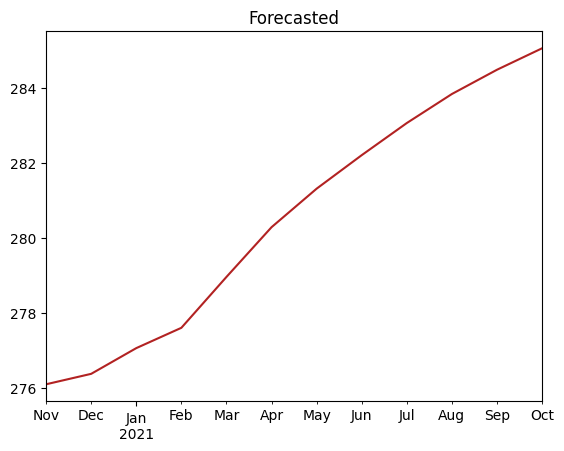

In [ ]:
observed = df_cpi.loc['2020-11-01':'2021-10-01',['ccpi']]
observed.plot(color = 'SteelBlue', title = 'Actual', legend = False)
plt.show()

predicted = pd.DataFrame(testY_hat, index=pd.date_range('2020-11-01',periods=12,freq='M'))
predicted.plot(color = 'Firebrick', title = 'Forecasted', legend = False)
plt.show()

In [ ]:
x_input = np.array(scaled[-12:])
x_input = x_input.reshape((1, n_steps_in, n_features))

forecast_normalized = multi_model.predict(x_input)

# Manually inverse Min-max normalization
max_cpi = df_cpi['ccpi'].max()
min_cpi = df_cpi['ccpi'].min()
forecast =  max_cpi-forecast_normalized[0][0]/(max_cpi-min_cpi)
print('The Core CPI value for the month Nov 2021 predicted by LSTM is ', forecast)

pct_chg = ((forecast - df_cpi.iloc[-12]['ccpi'])/df_cpi.iloc[-12]['ccpi']) * 100
print('The forecasted U.S. Core Consumer Price Index (CPI) YoY is ' , round(pct_chg,2))

1/1 [==============================] - 0s 28ms/step
The Core CPI value for the month Nov 2021 predicted by LSTM is  281.6889051873701
The forecasted U.S. Core Consumer Price Index (CPI) YoY is  4.4
